### Data

In [1]:
pd.set_option('display.max_colwidth',1500)

In [2]:
df = pd.read_pickle('data/df.pkl')
print(df.shape)
df[:2]

(84754, 21)


,AuthorID,Author,Date,Content,Attachments,Reactions,Date_day,Date_month,Date_quarter,id1,Channel1,Channel2,Channel2_img,flg_bot,Content2,cnt_messages,cnt_reactions,cnt_attachments,cnt_words,cnt_chars,flg_join
30165,451343325018980353,sheridan_oceanprotocol,2019-08-20 19:55:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30165,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1
30166,236850565382930432,kremalicious,2019-08-20 22:22:00,Joined the server.,NaN,NaN,2019-08-20,2019-08,2019Q3,30166,GENERAL,general-chat,💭,0,joined the server,0,0,0,3,18,1


### Spam searching

In [3]:
# https://huggingface.co/Titeiiko/OTIS-Official-Spam-Model

In [4]:
# text preprocessing
# df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('http.*', 'http', x))
# df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('@[A-Za-z0-9_]+','user', x))

# filtering
f0 = df['cnt_words'] > 1
f01 = df['cnt_words'] < 512
f1 = df['flg_join'] == 0
f2 = df['flg_bot'] == 0
# f2 = df['Author'] == 'Deleted User'

filt = f0&f1&f2

df1 = df[filt].sort_values(['Channel2','Date'])
print(df1.shape)

(26777, 21)


619507


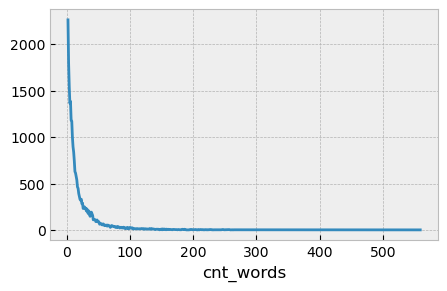

In [5]:
print(df1.cnt_words.sum())
_ = df1['cnt_words'].value_counts().sort_index().plot(figsize = (5,3))

In [6]:
from transformers import pipeline

model = pipeline("text-classification", model="Titeiiko/OTIS-Official-Spam-Model")

In [7]:
txt = "Cһeck out our amazinɡ bооѕting serviсe ѡhere you can get to Leveӏ 3 for 3 montһs for just 20 USD."
model(txt)

[{'label': 'LABEL_1', 'score': 0.9999815225601196}]

In [8]:
text = [l[:512] for l in list(df1['Content'])]
# text = [l for l in list(df1['Content'])]
len(text)

26777

In [9]:
t1 = dt.now()
list_out = model(text, return_all_scores = False)
print(dt.now() - t1)

0:01:27.364360


In [10]:
df0 = pd.DataFrame(list_out)
display(df0[:5])
df0['label'].value_counts()

,label,score
0,LABEL_1,1.00
1,LABEL_0,0.73
2,LABEL_0,1.00
3,LABEL_0,1.00
4,LABEL_0,1.00


label
LABEL_0    19306
LABEL_1     7471
Name: count, dtype: int64

In [11]:
feats = ['Author','Date','Content','Channel2','label','score']
df2 = pd.concat([df1, df0], axis = 1)[feats]
df2[:10]

,Author,Date,Content,Channel2,label,score
15793,white_rider_,2023-03-23 21:56:00,@OceanDiffusion Generate a random image with a beatiful ocean please,ai-fun,LABEL_0,1.00
15795,doteth,2023-03-24 03:30:00,@OceanGPT I want to build a data-driven dapp using data monetisation features from Ocean Protocol. What’s the best use case for a token-gated dapp?,ai-fun,LABEL_0,1.00
15797,doteth,2023-03-24 03:31:00,@OceanDiffusion can you design a basic landing page for a data marketplace?,ai-fun,LABEL_0,1.00
15799,doteth,2023-03-24 03:32:00,@OceanDiffusion maybe you’re better with memes. Please generate a meme about Ocean Protocol,ai-fun,LABEL_1,1.00
15803,networkstate,2023-03-24 06:56:00,muscular donut man bathing in thermal power plant cooling water basically,ai-fun,LABEL_0,1.00
15805,jonathanbytesio,2023-03-24 13:38:00,Hi alll,ai-fun,LABEL_0,1.00
15807,jonathanbytesio,2023-03-24 13:39:00,The ambassador channel already gated,ai-fun,LABEL_0,1.00
15808,jonathanbytesio,2023-03-24 13:39:00,I have ambassador role why can’t send msg,ai-fun,LABEL_0,1.00
15806,jonathanbytesio,2023-03-24 13:39:00,And @Andrea | Ocean Protocol,ai-fun,LABEL_0,1.00
15809,doteth,2023-03-24 13:45:00,"Fixed, thanks for reporting",ai-fun,LABEL_1,1.00


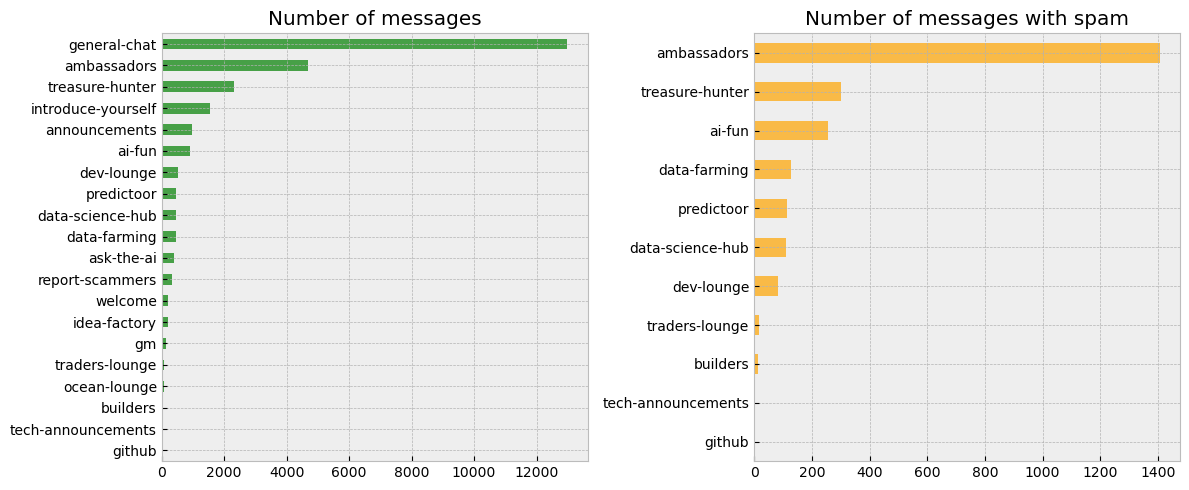

In [12]:
# cnt
_, ax = plt.subplots(1,2, figsize = (12,5))

x = df2['Channel2'].value_counts()
_ = x.sort_values(ascending = True).plot(ax = ax[0], kind = 'barh', alpha = 0.7, color = 'Green', title = 'Number of messages', ylabel = '')

f1 = df2['label'] == 'LABEL_1'
x = df2[f1].groupby(['Channel2']).size()
_ = x.sort_values(ascending = True).plot(ax = ax[1], kind = 'barh', alpha = 0.7, color = 'Orange', title = 'Number of messages with spam', ylabel = '')

plt.tight_layout()

In [13]:
print(df2['Channel2'].unique())

['ai-fun' 'ambassadors' 'announcements' 'ask-the-ai' 'builders'
 'data-farming' 'data-science-hub' 'dev-lounge' 'general-chat' 'github'
 'gm' 'idea-factory' 'introduce-yourself' 'ocean-lounge' 'predictoor'
 'report-scammers' 'tech-announcements' 'traders-lounge' 'treasure-hunter'
 'welcome' nan]


In [14]:
f1 = df2['label'] == 'LABEL_1'
f2 = df2['Channel2'] == 'ambassadors'
df2[f1&f2].sort_values('score', ascending= False)[:10]

,Author,Date,Content,Channel2,label,score
24705,blockchainlugano,2023-08-16 21:14:00,@Rain | Ocean @Bhalisa @KreigDk 🔥 Can you add your tweet/tiktok thread from this weeks bounties here (https://docs.google.com/spreadsheets/d/14upEOy_slBoiWegN9gsScP2ugMvdN8LcfOxbDYYOIPI/edit?usp=sharing) so that other ambassadors can see it? I know some of you want to see each others work.,ambassadors,LABEL_1,1.00
24983,kreigdk,2023-10-04 00:08:00,Need a meme about ambassadors?\nor can we do a recruit meme too?,ambassadors,LABEL_1,1.00
23128,wanderclyffex,2022-10-09 14:13:00,Ah thanks,ambassadors,LABEL_1,1.00
23151,QueenPat#9259,2022-10-15 20:46:00,"@blockchainlugano @zippy1979 \n\nThank you for the opportunity to moderate the #🖖︱introduce-yourself channel in the past two months. It was quite a pleasure.\n\nAnd just for the records, @Ambassador \n\nI hereby discontinue from carrying out the #🖖︱introduce-yourself channel moderation duties until I am paid for the last two months of delivery. \n\nRegards.",ambassadors,LABEL_1,1.00
20183,0xnoe,2021-08-05 21:21:00,"Hi, please send me a pm with your signed pledge + link to your academy certificate",ambassadors,LABEL_1,1.00
24773,cesar_cripto,2023-08-26 04:54:00,"thanks! im trying to vote but it seems there is an issue about RPC node, does anyone have the same issue or just me? or maybe should i change the RPC config of my wallet?",ambassadors,LABEL_1,1.00
24873,cesar_cripto,2023-09-16 01:33:00,gm! i sent u dm,ambassadors,LABEL_1,1.00
24215,doteth,2023-06-06 18:44:00,Would reallyyyy be surprised if someone can guess what is cooking! Hence the prize 😎,ambassadors,LABEL_1,1.00
22534,facundo3475,2022-06-16 15:11:00,Como se puede ser embajador cesar ?,ambassadors,LABEL_1,1.00
23157,lubomir16,2022-10-16 19:05:00,So our amazing guy @Wanderclyffe | Ocean Protocol started to do amazing threads on our Twitter. I am enjoying it very much. What is your opinion? 🥰,ambassadors,LABEL_1,1.00


### Scam searching

In [30]:
# text preprocessing
# df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('http.*', 'http', x))
# df['Content'] = df['Content'].fillna('').map(lambda x: re.sub('@[A-Za-z0-9_]+','user', x))

# filtering
f0 = df['cnt_words'] > 0
f1 = df['flg_join'] == 0
# f2 = df['flg_bot'] == 0
f2 = df['Author'] == 'Deleted User'
# f3 = df['Content2'].str.contains('scam')

filt = f0&f1&f2

df1 = df[filt].sort_values(['Date'])
print(df1.shape)

(473, 21)


In [32]:
list1 = [
    15365,
    18201,
    39315,
    35835,
    35634,
    34202,
    56159,
    56284,
    33241,
]
df1.loc[list1,:]

,AuthorID,Author,Date,Content,Attachments,Reactions,Date_day,Date_month,Date_quarter,id1,Channel1,Channel2,Channel2_img,flg_bot,Content2,cnt_messages,cnt_reactions,cnt_attachments,cnt_words,cnt_chars,flg_join
15365,456226577798135808,Deleted User,2023-12-01 10:54:00,LOL I missed out on 100k cuz I paperhanded shiba\ncheck yours i wonder who has the high score xd \n🔗 https://cealits-paper-handsorg.org,NaN,NaN,2023-12-01,2023-12,2023Q4,15365,CORE-TECH,github,🛳,1,lol i missed out on 100k cuz i paperhanded shiba\ncheck yours i wonder who has the high score xd \n httpscealitspaperhandsorgorg,1,0,0,21,133,0
18201,456226577798135808,Deleted User,2023-11-11 13:17:00,"We have collaborated with OPENSEA on a new free mint. Users in this server can participate.\n\n🚀 @everyone @here You can be selected, please participate in [MINT](https://claimdrop-opensea.web.app) as soon as possible.",NaN,NaN,2023-11-11,2023-11,2023Q4,18201,ECOSYSTEM,traders-lounge,📈,1,we have collaborated with opensea on a new free mint users in this server can participate\n\n everyone here you can be selected please participate in minthttpsclaimdropopenseawebapp as soon as possible,1,0,0,30,216,0
39315,456226577798135808,Deleted User,2022-10-18 14:22:00,Dropping our links here so that you could check them out 🙂\n\n\n\nAffordable UI/UX Visualization service\n\nWe deliver. Period.\n\n\n**Portfolio** https://bit.ly/3lxOqwo\n**Get an Estimate** https://bit.ly/3wygFRD\n\n\nProject Manager | déaccel partners\nAffordable UI/UX visualization\nWe deliver. Period.\n\nBR | déaccel partners,NaN,NaN,2022-10-18,2022-10,2022Q4,39315,GENERAL,general-chat,💭,1,dropping our links here so that you could check them out \n\n\n\naffordable uiux visualization service\n\nwe deliver period\n\n\nportfolio httpsbitly3lxoqwo\nget an estimate httpsbitly3wygfrd\n\n\nproject manager déaccel partners\naffordable uiux visualization\nwe deliver period\n\nbr déaccel partners,1,0,0,37,314,0
35835,456226577798135808,Deleted User,2021-12-29 03:39:00,"Hi ICO enthusiasts, would anyone here be interested in conducting research for upcoming projects? If so, PM me and I’m sure that it will be worth your time and effort.",NaN,NaN,2021-12-29,2021-12,2021Q4,35835,GENERAL,general-chat,💭,1,hi ico enthusiasts would anyone here be interested in conducting research for upcoming projects if so pm me and im sure that it will be worth your time and effort,1,0,0,30,167,0
35634,456226577798135808,Deleted User,2021-12-13 09:33:00,"Hi ICO enthusiasts, would anyone here be interested in conducting research for upcoming projects? If so, PM me and I’m sure that it will be worth your time and effort.",NaN,NaN,2021-12-13,2021-12,2021Q4,35634,GENERAL,general-chat,💭,1,hi ico enthusiasts would anyone here be interested in conducting research for upcoming projects if so pm me and im sure that it will be worth your time and effort,1,0,0,30,167,0
34202,456226577798135808,Deleted User,2021-06-05 02:25:00,Our idea is to establish a decentralised streaming platform. Checkout our application at:\n\nhttps://vote.oceanprotocol.com/#/officialoceandao.eth/proposal/Qmca7fw5EmZD4BC9YCLD1tqTzUEPCo8qxsY39c6ZVSesHZ,NaN,NaN,2021-06-05,2021-06,2021Q2,34202,GENERAL,general-chat,💭,1,our idea is to establish a decentralised streaming platform checkout our application at\n\nhttpsvoteoceanprotocolcomofficialoceandaoethproposalqmca7fw5emzd4bc9ycld1tqtzuepco8qxsy39c6zvseshz,1,0,0,14,200,0
56159,456226577798135808,Deleted User,2021-05-11 23:50:00,http://essayus.ml - Order essay writing online! Smarter and faster than your profs!,https://cdn.discordapp.com/attachments/727898674637832274/841703938092040203/269.jpg?ex=65de04e0&is=65cb8fe0&hm=14775b4c662150129034bfc718d41d88dabd7a67f35d3a8c14a4d65e295cf1b8&,NaN,2021-05-11,2021-05,2021Q2,56159,GET STARTED,welcome,👋,1,httpessayusml order essay writing online smarter and faster than your profs,1,0,1,11,83,0
56284,456226577798135808,Deleted User,2021-05-14 10:04:00,http://extraservice.ml - Cool writing service,https:/

In [ ]:
# f1 = df['Channel2'] == 'report-scammers'
# print(df[f1].shape)
# df[f1]

In [ ]:
# This seems like a very elaborate scam - the domain oceangift.org leads to oceanrewards.net which asks to connect the wallet
# Does ocean protocol have a job platform where users help with app optimization? Think it is a scam? This was the website I was given.\n\nhttps://www.oceanusd.com/index/user/login.html	
# Hello @xbxh,\nOcean Protocol does not have a support ticket.\n\nPlease Just block them.
# hello\nI have a question\nis this website leggit: oceantoken.net\n?	